In [13]:
import os
os.getcwd()
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Concatenate, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [19]:
imdb_data = pd.read_csv("IMDB Dataset.csv")
print(imdb_data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [20]:
# pos, neg 값을 숫자로 변형(1, 0)
imdb_data['sentiment'] = imdb_data['sentiment'].replace('positive', 1)
imdb_data['sentiment'] = imdb_data['sentiment'].replace('negative', 0)


# 전처리---------------------------------------------------------------
# 1) 단어가 아니면 삭제
imdb_data['review'] = imdb_data['review'].str.replace("[^\w]|br", " ")
# 2) 공백만 있는 경우 null array로 변환
imdb_data['review'] = imdb_data['review'].replace('', np.nan)
imdb_data['sentiment'] = imdb_data['sentiment'].replace('', np.nan)
# 3) null인 행 제거
imdb_data = imdb_data.dropna(how='any', axis=0)
print("# preprocessing done")
#---------------------------------------------------------------------

review_train, review_test, y_train, y_test = train_test_split(imdb_data['review'], imdb_data['sentiment'], shuffle=False, random_state=34)
     # default : test_size = 0.25
print("# split done")
#---------------------------------------------------------------------

# 리뷰 문장 -> 토크나이즈(using split)
stopwords = ['a', 'an', 'the']

X_train = []
for stc in review_train:
    token = []
    words = stc.split()
    for word in words:
      if word not in stopwords:
        token.append(word)
    X_train.append(token)

X_test = []
for stc in review_test:
    token = []
    words = stc.split()
    for word in words:
      if word not in stopwords:
        token.append(word)
    X_test.append(token)
print("# tokenization done")
#-----------------------------------------------------------------------

# 단어 -> 정수 인코딩
# 임베딩 전 컴퓨터가 단어를 구별할 수 있도록 함. OHE로 바꿔서 하는 것과 동일한 맥락
tokenizer = Tokenizer(5000)
tokenizer.fit_on_texts(X_train) # 각 단어에 정수 인덱스를 부여
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print("# int_encoding done")

# preprocessing done
# split done
# tokenization done
# int_encoding done


194.66568
4705.0
1743.0
[108.34]


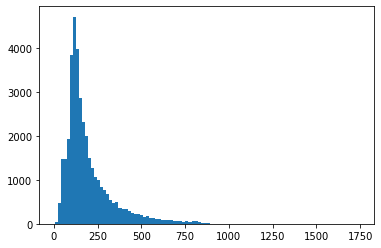

In [21]:
import matplotlib.pyplot as plt

len_stc = []
for data in X_train:
    len_stc.append(len(data))

y, x, _ = plt.hist(len_stc, bins=100)
print(sum(len_stc)/len(len_stc))
print(y.max())
print(x.max())
print(x[np.where(y==y.max())])

In [22]:
# 문장마다 길이가 다르므로 길이를 맞춰주기
# 문장마다 embedding layer를 통과하게 할 것이기 때문

# max_len은 데이터셋을 보면서 최대 문장의 길이로 설정
# max_len = max([len(x) for x in X_train]) # 1743
max_len = 200
X_train = pad_sequences(X_train, maxlen=max_len) # 더 길면 자르고, 짧으면 0을 추가
X_test = pad_sequences(X_test, maxlen=max_len)

In [23]:
print(X_train[0])

[  55   15    3 1437  376   38  562   90    4 3686    6  362  356    2
  658    5    4  435 2916   13    9    4  359    3 2590 1063    5 2683
 1422   21  514 4799 2458    2 1164  114   29   26 2820    1  389   34
    4   22  302   21 4772 1689  514    4  348    3  105 4746 2374    1
   49   34  327    1   24  110  228  239    7   58  132  285 1322    2
  117    4  683    3  191    9    5  271  114   70  278  586   20 3064
  830  181 1320 4259   16 2447 1205  830 1418  830  877 2916  155   20
  950  186   12   85  410    7  122  210 3229   66   13   34 1599    5
   11 2306    7  421   20  132    7   11 1593   16    5   17   13    7
  292   49    7 1425 1294   16 2916    1  192    3  302 2132    2 2205
  562   22   39  562   17   33  229   28 2841   41   16   33  229  506
   21  624    1   74  239   15    5   67  652  689  108  648   81 1164
  683    3   64  560    2  894 2095   38 1164  542  147 2916   19  202
  434 3712   15   45    4 3407  808 1666   43   19   48   74    6 1190
   15 

In [24]:
# 모델 생성-------------------------------------------
# CNN 모델 : Embedding → Conv → Pooling → Flatten → Dense

model = Sequential()
# 단어 임베딩 -> 5000개의 단어를 256차원으로 내보내겠다(정수 -> 256 dimension vector)
model.add(Embedding(5000, 256))
model.add(Conv1D(256, 3, padding='valid', activation='relu')) # 커널 수: 256, 커널의 크기: 3(단어를 3개씩 봄)
model.add(GlobalMaxPooling1D()) # 모든 feature map에서 max pooling을 해서 하나의 vector로 full layer를 위한 출력값이 나옴 
# model.add(Flatten()) # 2차원이상의 CNN에서 사용
model.add(Dense(1, activation='sigmoid'))
#------------------------------------------------------

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4)

Epoch 1/4
1172/1172 [==============================] - 202s 173ms/step - loss: 0.2493 - acc: 0.8980 - val_loss: 0.2390 - val_acc: 0.9026
Epoch 2/4
1172/1172 [==============================] - 205s 175ms/step - loss: 0.1418 - acc: 0.9491 - val_loss: 0.2557 - val_acc: 0.9011
Epoch 3/4
1172/1172 [==============================] - 199s 170ms/step - loss: 0.0574 - acc: 0.9842 - val_loss: 0.2977 - val_acc: 0.8975
Epoch 4/4
1172/1172 [==============================] - 193s 164ms/step - loss: 0.0171 - acc: 0.9969 - val_loss: 0.3798 - val_acc: 0.8937


In [ ]:
# 앙상블 모델 생성-------------------------------------------
# CNN 모델 : Embedding → Conv → Pooling → Flatten → Dense
# 함수형 API 사용

# 함수형 케라스 -- 복잡한 모델을 구현할 때 사용
inputs = Input(shape=(200, ))
embed = Embedding(5000, 256)(inputs)


# 모델 합성
concat_layers = []

conv = Conv1D(256, 3, padding='valid', activation='relu')(embed)
pool = GlobalMaxPooling1D()(conv)
flat = Flatten()(pool)
concat_layers.append(flat)

conv = Conv1D(256, 4, padding='valid', activation='relu')(embed)
pool = GlobalMaxPooling1D()(conv)
flat = Flatten()(pool)
concat_layers.append(flat)

conv = Conv1D(256, 5, padding='valid', activation='relu')(embed)
pool = GlobalMaxPooling1D()(conv)
flat = Flatten()(pool)
concat_layers.append(flat)

####
concat = Concatenate(concat_layers)
outputs = Dense(1, activation='sigmoid')(concat)
model = Model(inputs, outputs)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4)